In [1]:
import keras
import os
os.environ['KERAS_BACKEND'] = 'theano'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)  # for reproducibility
from sklearn.metrics import mean_squared_error

from sklearn.datasets import make_swiss_roll

from theano import function

from keras.datasets import mnist
from keras.models import Sequential
from numpy.random import normal
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, Layer
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

from seya.layers.variational import VariationalDense as VAE
from seya.layers.convolutional import GlobalPooling2D
from seya.utils import apply_model
from seya.layers.regularization import ITLRegularizer
from seya.parzen import ParzenWindows

from agnez import grid2d, embedding2dplot
import math

Using Theano backend.


In [3]:
code_size = 2
# input image dimensions
img_rows, img_cols = 28, 28
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
X_train = X_train.astype("float32").reshape((-1, 784))
X_test = X_test.astype("float32").reshape((-1, 784))
X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_valid = X_train[50000:]
Y_valid = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

X_train shape: (60000, 784)
60000 train samples
10000 test samples


In [ ]:
#add mix_Gaussian source noise
noise_v1 = 1
noise_v2 = 10
A = .5
noise_factor = 0.01
source_noise_train = (1-A) * normal(0, np.sqrt(noise_v1), X_train.shape) + A * normal(0, np.sqrt(noise_v2), X_train.shape)
source_noise_valid = (1-A) * normal(0, np.sqrt(noise_v1), X_valid.shape) + A * normal(0, np.sqrt(noise_v2), X_valid.shape)
source_noise_test = (1-A) * normal(0, np.sqrt(noise_v1), X_test.shape) + A * normal(0, np.sqrt(noise_v2), X_test.shape)
x_train_noisy = X_train + noise_factor*source_noise_train
x_valid_noisy = X_valid + noise_factor*source_noise_valid
x_test_noisy = X_test + noise_factor*source_noise_test

In [ ]:
# four Gaussian prior distribution
# size is the number of samples for each Gaussian
# scalar can change the distance between the Gaussian
mix_gaussian_scalar=2.
def gaussian_mixture_4(size, scalar=mix_gaussian_scalar):
    size = 400
    mean1 = [4.*scalar, 0.*scalar]
    mean2 = [0*scalar, 4*scalar]
    mean3 = [-4.*scalar, 0.*scalar]
    mean4 = [0.*scalar, -4.*scalar]

    cov1 = [[5., 0.], [0., 1.]]
    cov2 = [[1, 0], [0, 5]]
    cov3 = [[5., 0.], [0., 1.]]
    cov4 = [[1., 0.], [0., 5.]]

    X1 = np.random.multivariate_normal(mean1, cov1, size)
    X2 = np.random.multivariate_normal(mean2, cov2, size)
    X3 = np.random.multivariate_normal(mean3, cov3, size)
    X4 = np.random.multivariate_normal(mean4, cov4, size)

    X = K.concatenate([X1, X2, X3, X4], axis=0)
    return X

In [ ]:
X1 = np.random.multivariate_normal([0,0],[[15,0],[0,15]],1000)
#X1 = K.random_normal(2, std=10)

plt.scatter(X1[:,0],X1[:,1])
plt.xlim(-25, 25)
plt.ylim(-25, 25)

In [14]:
def my_awgn(sig,SNR):
    np.random.seed(1337)
    sigPower= sum(sum(abs(sig)**2))/(sig.shape[0]*sig.shape[1])
    sigPower = 10*math.log10(sigPower)
    noisePower = sigPower - SNR
    p = 10**(noisePower/10)
    noise = (np.sqrt(p))*np.random.randn(sig.shape[0],sig.shape[1])
    noise_sig = sig + noise
    return noise_sig

In [5]:
pri_lambda = 1
pri_scale = 0.1
pri_ksize = 6.
pri_alpha = 0.1

#encoder architecture
enc = Sequential()
enc.add(Dense(1000, input_dim=784, activation='relu'))
enc.add(BN())
enc.add(Dense(1000, activation='relu'))
enc.add(BN())
enc.add(Dense(2))
enc.add(ITLRegularizer(distance='pri', scale=pri_scale, ksize=pri_ksize, pri_lambda=pri_lambda,pri_alpha=pri_alpha
                       #distribution=gaussian_mixture_10                
                     ))
#enc.add(ITLRegularizer(distance='csd', scale=0.2, ksize=6.
                      #))

#decoder architecture
dec = Sequential()
dec.add(Dense(1000, input_dim=2, activation='relu'))
dec.add(Dense(784, activation='sigmoid'))

In [6]:
#compile the model and using c-loss cost funciton
#closs_ksize = 4.0
#ksize = closs_ksize
model = Sequential()
model.add(enc)
model.add(dec)
model.compile(loss='mse', optimizer='adam')
model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 784)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Sequential (Unnamed)          (None, 2)                     1792002             
Sequential (Unnamed)          (None, 784)                   787784              
--------------------------------------------------------------------------------
Total params: 2579786
--------------------------------------------------------------------------------


In [7]:
cbk = ModelCheckpoint('itl_mnist_gaussian1_pri_std1_scale_0.1.hdf5', save_best_only=True, verbose=True)

model.fit(X_train, X_train.reshape((-1, 784)), batch_size=1000, nb_epoch=50, verbose=2,
      validation_data=(X_valid, X_valid.reshape((-1, 784))),
      callbacks=[cbk]
    )

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
Epoch 00000: val_loss improved from inf to 0.11108, saving model to itl_mnist_gaussian1_pri_std1_scale_0.1.hdf5
28s - loss: 0.1163 - val_loss: 0.1111
Epoch 2/50
Epoch 00001: val_loss improved from 0.11108 to 0.08079, saving model to itl_mnist_gaussian1_pri_std1_scale_0.1.hdf5
27s - loss: 0.0859 - val_loss: 0.0808
Epoch 3/50
Epoch 00002: val_loss improved from 0.08079 to 0.07025, saving model to itl_mnist_gaussian1_pri_std1_scale_0.1.hdf5
27s - loss: 0.0809 - val_loss: 0.0702
Epoch 4/50
Epoch 00003: val_loss did not improve
26s - loss: 0.0785 - val_loss: 0.0713
Epoch 5/50
Epoch 00004: val_loss did not improve
27s - loss: 0.0769 - val_loss: 0.0709
Epoch 6/50
Epoch 00005: val_loss improved from 0.07025 to 0.06815, saving model to itl_mnist_gaussian1_pri_std1_scale_0.1.hdf5
27s - loss: 0.0752 - val_loss: 0.0681
Epoch 7/50
Epoch 00006: val_loss did not improve
26s - loss: 0.0749 - val_loss: 0.0723
Epoch 8/50
Epoch 00007: val_loss 

In [20]:
#model.load_weights('itl_mnist_gaussian1_mse_pri_alapha0.2_lambda1_scale_0.2.hdf5')
#model.load_weights('itl_mnist_gaussian1_pri_std1.hdf5')
model.load_weights('itl_mnist_gaussian1_mse.hdf5')

In [21]:
X = K.placeholder(ndim=2)
Y = dec(X)
F_dec = function([X], Y, allow_input_downcast=True)
X = K.placeholder(ndim=2)
Y = enc(X)
F_enc = function([X], Y, allow_input_downcast=True)

In [22]:
y_dec.shape

(100, 784)

In [23]:
#no source noise
y = F_enc(X_train[:100,:])
#add channel noise
y_noisy = my_awgn(y,18) 
y_noise_dec = F_dec(y_noisy)# add channel noise
y_dec = F_dec(y)# no channel noise

Text(0.5, 1.0, 'channel_noise = 14dB')

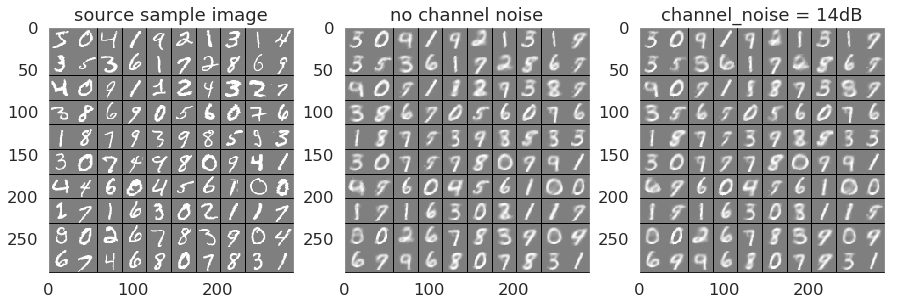

In [24]:
plt.figure(figsize = (15,8))
I_source_noise = grid2d(y_dec.reshape((100, -1)))
#channel noise
I_channel_noise = grid2d(y_noise_dec.reshape((100, -1)))
#source sample images
I = grid2d(X_train[:100].reshape((100, -1)))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('source sample image')
plt.subplot(1,3,2)
plt.imshow(I_source_noise, cmap='gray')
plt.title('no channel noise')
plt.subplot(1,3,3)
plt.imshow(I_channel_noise, cmap='gray')
plt.title('channel_noise = 14dB')

In [25]:
mse_loss = mean_squared_error(X_train[:100,:],y_noise_dec)
mse_loss

0.042429481

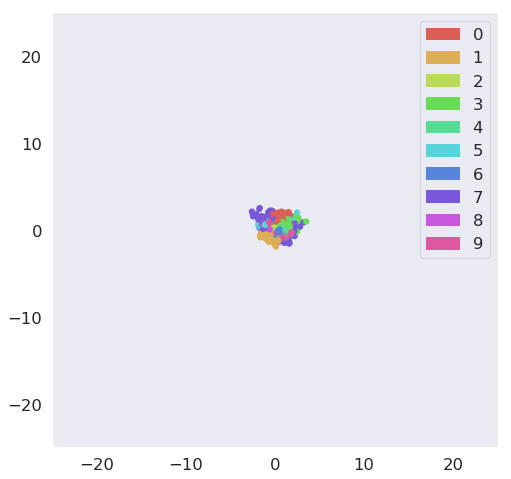

In [10]:
#Bottleneck layer codes visualization
#import matplotlib.patches as mpatches
y = F_enc(X_train[:6000])
_ = embedding2dplot(y, y_train[:6000], show_median=False)
#five_patch = mpatches.Patch(color='magenta', label='5')
#four_patch = mpatches.Patch(color='blue', label='4')
#one_patch = mpatches.Patch(color='y', label='1')
#zero_patch = mpatches.Patch(color='red', label='0')
#plt.legend(handles=[zero_patch,one_patch,four_patch,five_patch])
plt.axis('on')
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.savefig('pri_latent-1.png')